In [7]:
from pathlib import Path
from IPython.display import display
import pickle

from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, recall_score, accuracy_score, precision_score, roc_auc_score
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import interpret
from interpret.glassbox import ExplainableBoostingClassifier
interpret.set_visualize_provider(interpret.provider.InlineProvider())

from nam.data import NAMDataset
from nam.config import defaults
from nam.data import FoldedDataset
from nam.models import NAM
from nam.models import get_num_units
from nam.trainer import LitNAM
from nam.types import Config
from nam.utils import parse_args
from nam.utils import plot_mean_feature_importance
from nam.utils import plot_nams
import pytorch_lightning as pl
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks.model_checkpoint import ModelCheckpoint

In [8]:
# all_data = pd.read_excel('All_Data.xlsx', sheet_name=None)
# all_data = pd.read_excel('All_Data.xlsx', sheet_name='CMBSMainDataFile.dta')
with open('all_data.pickle', 'rb') as file:
    all_data = pickle.load(file)
all_data

array([[<Axes: title={'center': 'non_perf'}>]], dtype=object)

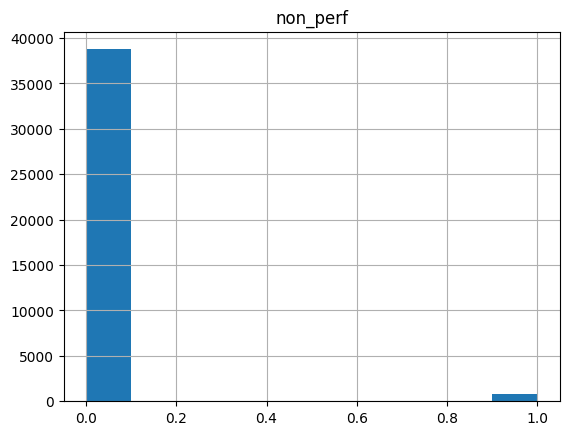

In [5]:
#Non-Perorming: A dummy variable equal to one if a loan becomes non performing at any point from April 2020 to April 2021. A loan is non-perfomring if it has missed a payment, is in the process of foreclosure, is real estate owned, or has been placed into special servicing.
# cmbs_main = all_data['CMBSMainDataFile.dta']
cmbs_main = all_data
cmbs_main[
    [
        'non_perf', 
        #'non_perf2',
    ]
].hist()


In [6]:
list(all_data.keys())

['leadmgr',
 'CurrentStatusDate',
 'CurrentStatus',
 'AmortType',
 'type',
 'NewStatus',
 'StatusHistoryNew',
 'CutoffCpn',
 'CutoffOcc',
 'CutoffLTV',
 'CutoffDSCR',
 'CutoffNOIUSD',
 'CutoffNCFUSD',
 'Originator',
 'year_priced',
 'Address',
 'MSA',
 'St',
 'ApprValUSD',
 'ValAsOf',
 'CutoffValUSD',
 'CapRate',
 'log_bal',
 'fixed',
 'BA',
 'IO',
 'PartialIO',
 'buildingage',
 'non_perf2',
 'qy',
 'PropType',
 'over_t_plus_1',
 'A',
 'Status',
 'StatusHistory',
 'CumMoDq',
 'CurrTrustBalUSD',
 'Cpn',
 'NetCpn',
 'RateType',
 'Protection',
 'Due',
 'MaturityType',
 'TargetBond',
 'OriginalBalUSD',
 'CutoffTrustBalUSD',
 'ScheduledBalloonUSD',
 'CutoffBalPerUnitUSD',
 'CurBalPerUnitUSD',
 'CurrOcc',
 'LTV',
 'DSCR',
 'RecNOIUSD',
 'NOIStartDt',
 'NOIEndDt',
 'RecentValUSD',
 'RecentValDt',
 'OriginationDt',
 'datevar',
 'OrigAmortization',
 'AssetGroup',
 'year',
 'pricing',
 'settle',
 'currmm',
 'origmm',
 'crcy',
 'tranche',
 'prvt_place',
 'io_total_orig',
 'dup',
 'loan_number',
 

In [8]:
kroll_data = all_data['KrollMatched.dta']
interesting_kroll_data_cols = [
    'propertytype',
    #'kbrapropertyscore', hat viele NANs
    'DSCR_NCF',
    'LoanStatus',
    'City',
]
# TODOS 
# LoanStatus und City umwandeln in numerische Daten

kroll_data[interesting_kroll_data_cols]

propertytype DSCR_NCF LoanStatus              City
0              MF     2.53    Perform          Pasadena
1              IN     0.72       Late       Cocoa Beach
2              MF     1.83    Perform        Middletown
3              MF      1.7    Perform       Porterville
4              OF     1.16    Perform  Bloomfield Hills
...           ...      ...        ...               ...
8106           MF     2.74    Perform     Missouri City
8107           MF      2.2    Perform      Jacksonville
8108           MF     2.69    Perform         Knoxville
8109           MH     1.39    Perform             Tampa
8110           RT     1.69    Perform            Tucson

[8111 rows x 4 columns]

In [9]:
deal_characteristics = all_data['DealCharacteristics.dta']
deal_characteristics_columns = [
    'prop_IO',
    'p_float',
    'dscr',
    'WAC',
    'type'
]

SyntaxError: invalid syntax (3356416252.py, line 3)

In [10]:
len(cmbs_main)

39522

In [11]:
len(kroll_data)

8111

In [12]:
pd.merge(cmbs_main, kroll_data, on=['Deal', 'LoanName'], how='left')

leadmgr_x CurrentStatusDate_x CurrentStatus_x    AmortType_x   type_x  \
0        WFS, CS             05/2020         Perform     Partial IO  Conduit   
1        DBS, CF             05/2020         Perform     Partial IO   Agency   
2       DBS, JPM             05/2020         Perform  Balloon Amort   Agency   
3        WFS, CS             05/2020         Perform     Partial IO  Conduit   
4        CS, BCG             05/2020         Perform    Fully Amort   Agency   
...          ...                 ...             ...            ...      ...   
39517  WFS, BAML             05/2020         Perform    Fully Amort   Agency   
39518   UBS, WFS             05/2020         Perform     Partial IO  Conduit   
39519         CS             05/2020         Perform             IO  Conduit   
39520        WFS             05/2020         Perform  Balloon Amort  Conduit   
39521    DEU, CF             05/2020         Perform     Partial IO  Conduit   

      NewStatus_x                                StatusHistoryNew_x  \
0            Late  CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC--   
1            Late  CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC------------   
2         Perform  DDDCCCCCCCCCWWWCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC   
3         Perform  CCCCCWWWWWWWWCCCCCCCCCCCCCCCCCCC----------------   
4      Perform(w)  CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC-------------   
...           ...                                               ...   
39517     Perform  CCCCCCCCCCCCCCCCCWWWCCCCCCCCCCCCCCC-------------   
39518     Perform  ---PCCCCCCCCCC-C--------------------------------   
39519     Perform  CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC   
39520     Perform  CCCCCCCCWWCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC   
39521     Perform  CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCWWWCCCCCCCCCCCC-   

       CutoffCpn_x  CutoffOcc_x  CutoffLTV_x  ...  MSA_quarter_PropertyType_y  \
0            5.190       0.9160        0.677  ...                         NaN   
1            3.990       1.0000        0.720  ...                         NaN   
2            4.695       0.9400        0.739  ...                         NaN   
3            4.610       0.9400        0.630  ...                         NaN   
4            4.270       0.9444        0.800  ...                         NaN   
...            ...          ...          ...  ...                         ...   
39517        4.810       0.7110        0.722  ...                         NaN   
39518        5.140       0.9640        0.800  ...                         NaN   
39519        5.300       0.9760        0.713  ...                         NaN   
39520        5.600       0.9200        0.382  ...                         NaN   
39521        3.750       0.8007        0.650  ...                         NaN   

       MSA_year_y  kroll_over ltv_kroll  ratioLTV quarter_prop_y  \
0             NaN         NaN       NaN       NaN            NaN   
1             NaN         NaN       NaN       NaN            NaN   
2             NaN         NaN       NaN       NaN            NaN   
3             NaN         NaN       NaN       NaN            NaN   
4             NaN         NaN       NaN       NaN            NaN   
...           ...         ...       ...       ...            ...   
39517         NaN         NaN       NaN       NaN            NaN   
39518         NaN         NaN       NaN       NaN            NaN   
39519         NaN         NaN       NaN       NaN            NaN   
39520         NaN         NaN       NaN       NaN            NaN   
39521         NaN         NaN       NaN       NaN            NaN   

      state_quarter_y state_group_y  MSA_quarter_y DLid_y  
0                 NaN           NaN            NaN    NaN  
1                 NaN           NaN            NaN    NaN  
2                 NaN           NaN            NaN    NaN  
3                 NaN           NaN            NaN    NaN  
4                 NaN           NaN            NaN    NaN  
...               ...           ...        

In [131]:
# list(pd.merge(deal_characteristics, cmbs_main, on='Deal').columns)
pd.merge(kroll_data, cmbs_main, on=['Deal'], how='right')
# pd.merge(deal_characteristics, cmbs_main, on=['Deal'])

v1  loan  ofprop propertytype     propertysubtype      kbramsa  \
0        NaN   NaN     NaN          NaN                 NaN          NaN   
1        NaN   NaN     NaN          NaN                 NaN          NaN   
2       97.0  14.0     1.0           MF         Cooperative  San Antonio   
3       10.0  79.0     1.0           OF              Garden      Seattle   
4       58.0  42.0     1.0           MF  MHC Age Restricted     New York   
...      ...   ...     ...          ...                 ...          ...   
465179  98.0  77.0     1.0           OF     Shadow Anchored     East Bay   
465180   NaN   NaN     NaN          NaN                 NaN          NaN   
465181   NaN   NaN     NaN          NaN                 NaN          NaN   
465182   NaN   NaN     NaN          NaN                 NaN          NaN   
465183   NaN   NaN     NaN          NaN                 NaN          NaN   

       kbramarkettier  kbrapropertyscore  cutoffbalance000     kncf000  ...  \
0                 NaN                NaN               NaN         NaN  ...   
1                 NaN                NaN               NaN         NaN  ...   
2                  1A                NaN           25950.0  524.318665  ...   
3                 NaN                NaN            9000.0  958.805847  ...   
4                 NaN                0.0            9000.0  247.296463  ...   
...               ...                ...               ...         ...  ...   
465179             2B                NaN           45500.0  336.926941  ...   
465180            NaN                NaN               NaN         NaN  ...   
465181            NaN                NaN               NaN         NaN  ...   
465182            NaN                NaN               NaN         NaN  ...   
465183            NaN                NaN               NaN         NaN  ...   

            qy2  ApartmentAgency ApartmentNonAgency  Retail  Hotel  Other  \
0       32015.0              1.0                0.0     0.0    0.0    0.0   
1       22013.0              1.0                1.0     0.0    0.0    0.0   
2       32017.0              1.0                0.0     0.0    0.0    1.0   
3       32017.0              1.0                0.0     0.0    0.0    1.0   
4       32017.0              1.0                0.0     0.0    0.0    1.0   
...         ...              ...                ...     ...    ...    ...   
465179  42014.0              1.0                0.0     0.0    1.0    0.0   
465180  22016.0              1.0                0.0     0.0    0.0    0.0   
465181  42014.0              1.0                0.0     0.0    0.0    1.0   
465182  12017.0              1.0                0.0     0.0    0.0    0.0   
465183  22017.0              1.0                0.0     0.0    0.0    0.0   

       Office                                             DLid_y  \
0         0.0                                                NaN   
1         0.0  bee7458a5d4bd9526c72eeb171ce94a0b81fceaad0f068...   
2         0.0  f8b4ba4d93e048d2117ad0ef47a2a619a8d87e16774bc3...   
3         0.0  f8b4ba4d93e048d2117ad0ef47a2a619a8d87e16774bc3...   
4         0.0  f8b4ba4d93e048d2117ad0ef47a2a619a8d87e16774bc3...   
...       ...                                                ...   
465179    0.0  8d670d946d152a2fae005e1bda44dd37d5a65e0122eeef...   
465180    0.0  144f8fb150e2c008e675ec4e5da6563904b33d39e0e8af...   
465181    0.0  e324b6bc0208f677fe9202905c7b9242443418042d1e8d...   
465182    0.0  1b6b3b78dd60df65e4c81eca4ddb3d0d45356b4b27e43a...   
465183    0.0  dac9d5b18d50b0e6c457c0a963d2dff4ed54bf22c7b324...   

        high_overstatement2_y  \
0                         0.0   
1                         0.0   
2                         0.0   
3                         0.0   
4                         0.0   
...                       ...   
465179                    0.0   
465180                    1.0   
465181                    0.0   
465182                    1.0   
465183                    0.0   

         

array([[<Axes: title={'center': 'Distress'}>]], dtype=object)

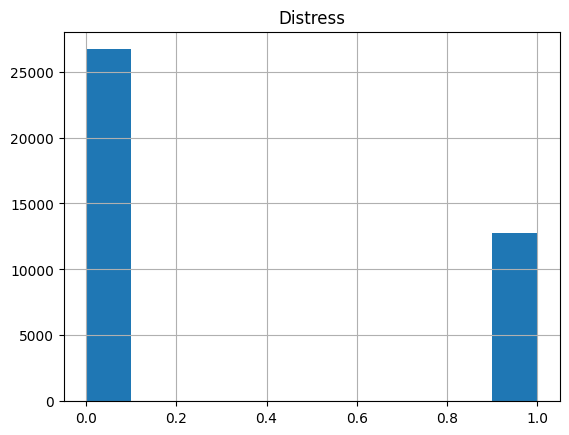

In [10]:
# Distress: A variable equal to one if a loan appears on a servicer's watchlist or becomes non-perfomring from April 2020 to April 2021. From variables AprilWatch, MayWatch, JuneWatch, JulyWatch, Augwatch, Sepwatch, Oct20Watch, Nov20Watch, Dec20Watch, Jan21Watch, Feb21Watch, Mar21Watch, Apr21Watch
#cmbs_main = all_data['CMBSMainDataFile.dta']
distress = cmbs_main[['Distress']]
cmbs_main[
    [
        'Distress', 
    ]
].hist()


#### Notes
- Kroll: income proejctions from Kroll (Kroll Net Cash Flow NCF) kroll data spalte DSCR_NCF, YearBuilt, orig (originator?), PropertyType, Deal (ID spalte), PropertyType (muss geschaut werden was abkürzungen bedeuten)
- Green-Street: initial price paid for CMBS tranches
- Green-Street: Risk Retention?
- ExecuComp: Executive Compensation
- SEC filings: Risk management practices
- Boomberg: Information on fixed income underwrtigin 'league tables'

In [11]:
# EDA
additional_columns = [
    'Originator',
    'ApprValUSD',
    'CapRate',
    'log_bal',
    'LTV',
    'DSCR',
    'Size',
    'RateType',
    'buildingage',
    'NOI',
    'Occupancy',
    'CutoffLTV',
    'CutoffCpn',
    'CutoffOcc',
    'CutoffDSCR',
    'CutoffNOIUSD',
    'CutoffNCFUSD', 
    'fixed',
] 

# age
# Rate type
# cmbs_main.columns.tolist()

In [12]:
data = cmbs_main[
    [
        'OVER_w',
        'past_over',
        'high_overstatement2', # is 100% dependent on Over_w, if we predict this we get 100% accuracy
        'Distress',
        'non_perf'
    ] + additional_columns
]
data = data.replace(' ', pd.NA)

In [13]:
target_col = 'high_overstatement2'

In [14]:
data['RateType']

0        Fixed
1        Fixed
2        Fixed
3        LIBOR
4        LIBOR
         ...  
39517    Fixed
39518    LIBOR
39519    Fixed
39520    Fixed
39521    Fixed
Name: RateType, Length: 39522, dtype: object

In [15]:
# Encode categorical data
data['Originator'] = LabelEncoder().fit_transform(data['Originator'])
data['RateType'] = LabelEncoder().fit_transform(data['RateType'])

In [16]:
clean_data = data[
    data.notna().all(axis=1)
]
clean_data

OVER_w  past_over  high_overstatement2  Distress  non_perf  \
0     -0.317393   0.186364                  0.0       1.0       0.0   
5     -0.008745   0.168498                  0.0       0.0       0.0   
6      0.086101   0.418182                  1.0       0.0       0.0   
9      0.023822   0.445026                  0.0       0.0       0.0   
10    -0.356910   0.328042                  0.0       0.0       0.0   
...         ...        ...                  ...       ...       ...   
39516  0.198225   0.285861                  1.0       0.0       0.0   
39517 -0.273799   0.112903                  0.0       1.0       0.0   
39519 -0.179458   0.117834                  0.0       0.0       0.0   
39520  0.100647   0.255241                  1.0       1.0       0.0   
39521 -0.235022   0.229585                  0.0       0.0       0.0   

       Originator  ApprValUSD   CapRate    log_bal    LTV  ...  buildingage  \
0             129  13240000.0  0.061237  17.073606  0.354  ...     2.890372   
5              65  40200000.0  0.087664  15.907374  0.718  ...     2.772589   
6              12   1540000.0  0.045671  14.659230  0.343  ...     3.465736   
9             114  23630000.0  0.054455  15.736249  0.727  ...     3.332205   
10            131   3150000.0  0.062622  14.950776  0.677  ...     2.639057   
...           ...         ...       ...        ...    ...  ...          ...   
39516          58  12300000.0  0.050276  19.113829  0.713  ...     0.693147   
39517          70  39000000.0  0.050974  16.183134  0.552  ...     3.496508   
39519          22  82500000.0  0.066112  16.404778  0.650  ...     3.583519   
39520          55   5250000.0  0.047434  15.571125  0.647  ...     3.044523   
39521           5  32800000.0  0.058111  16.906553  0.559  ...     2.708050   

              NOI  Occupancy  CutoffLTV  CutoffCpn CutoffOcc  CutoffDSCR  \
0        234100.0       0.94      0.677      5.190    0.9160       1.296   
5       1216909.0       0.95      0.627      4.100    1.0000       1.330   
6       2192208.0       0.95      0.463      3.880    0.8070       1.459   
9        384367.0       0.98      0.647      3.900    0.9800       2.808   
10      1740917.0       0.95      0.738      4.867    1.0000       5.604   
...           ...        ...        ...        ...       ...         ...   
39516  18215154.0       0.79      0.641      4.540    0.9480       7.580   
39517    919807.0       0.98      0.722      4.810    0.7110       2.430   
39519   1089638.0       0.91      0.713      5.300    0.9760       1.353   
39520    221662.0       0.98      0.382      5.600    0.9200       1.992   
39521    191032.0       0.99      0.650      3.750    0.8007       1.450   

       CutoffNOIUSD  CutoffNCFUSD  fixed  
0      2.858090e+05  2.096020e+05    1.0  
5      8.006000e+04  6.310640e+05    1.0  
6      5.339140e+05  2.904090e+05    0.0  
9      1.456530e+06  8.659251e+04    1.0  
10     1.635034e+06  1.872431e+06    1.0  
...             ...           ...    ...  
39516  1.687940e+05  7.858894e+06    1.0  
39517  2.841116e+06  5.992500e+04    1.0  
39519  1.001470e+05  2.082240e+05    1.0  
39520  1.436466e+06  2.023090e+05    0.0  
39521  1.449399e+06  5.494210e+05    0.0  

[24300 rows x 23 columns]

In [17]:
clean_data = clean_data.astype({'Occupancy': float})

In [18]:
for col, dtype in clean_data.dtypes.to_dict().items():
    if not dtype == int:
        dat = clean_data[col]
        X_scaled = (dat - dat.min(axis=0)) / (dat.max(axis=0) - dat.min(axis=0))
        # X_scaled = X_scaled * (1 - min) + min
        clean_data[col] = X_scaled

In [19]:
clean_data.dtypes

OVER_w                 float64
past_over              float64
high_overstatement2    float64
Distress               float64
non_perf               float64
Originator               int64
ApprValUSD             float64
CapRate                float64
log_bal                float64
LTV                    float64
DSCR                   float64
Size                   float64
RateType                 int64
buildingage            float64
NOI                    float64
Occupancy              float64
CutoffLTV              float64
CutoffCpn              float64
CutoffOcc              float64
CutoffDSCR             float64
CutoffNOIUSD           float64
CutoffNCFUSD           float64
fixed                  float64
dtype: object

array([[<Axes: title={'center': 'OVER_w'}>,
        <Axes: title={'center': 'past_over'}>,
        <Axes: title={'center': 'high_overstatement2'}>,
        <Axes: title={'center': 'Distress'}>,
        <Axes: title={'center': 'non_perf'}>],
       [<Axes: title={'center': 'Originator'}>,
        <Axes: title={'center': 'ApprValUSD'}>,
        <Axes: title={'center': 'CapRate'}>,
        <Axes: title={'center': 'log_bal'}>,
        <Axes: title={'center': 'LTV'}>],
       [<Axes: title={'center': 'DSCR'}>,
        <Axes: title={'center': 'Size'}>,
        <Axes: title={'center': 'RateType'}>,
        <Axes: title={'center': 'buildingage'}>,
        <Axes: title={'center': 'NOI'}>],
       [<Axes: title={'center': 'Occupancy'}>,
        <Axes: title={'center': 'CutoffLTV'}>,
        <Axes: title={'center': 'CutoffCpn'}>,
        <Axes: title={'center': 'CutoffOcc'}>,
        <Axes: title={'center': 'CutoffDSCR'}>],
       [<Axes: title={'center': 'CutoffNOIUSD'}>,
        <Axes: title={'

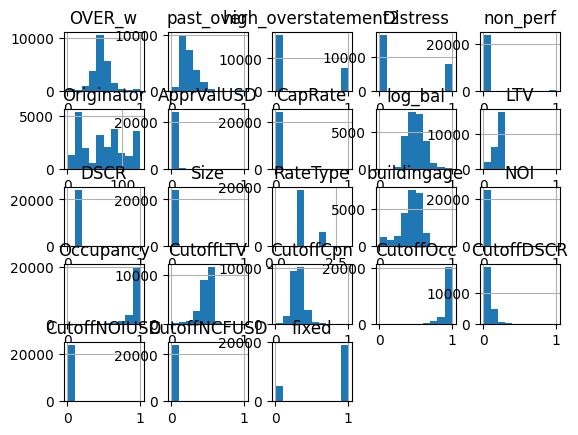

In [20]:
clean_data.hist()

In [21]:
# Percentage of clean data from whole dataset
len(clean_data) / len(data)

0.6148474267496584

In [22]:
target = clean_data[target_col]
X = clean_data.drop(columns=target_col)

In [23]:
sample_size = len(target) 
sample_size

24300

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X.head(sample_size), target.head(sample_size), random_state=42)

In [26]:
X_train_oversampled, y_train_oversampled = SMOTE().fit_resample(X_train, y_train)

array([[<Axes: title={'center': 'OVER_w'}>,
        <Axes: title={'center': 'past_over'}>,
        <Axes: title={'center': 'Distress'}>,
        <Axes: title={'center': 'non_perf'}>,
        <Axes: title={'center': 'Originator'}>],
       [<Axes: title={'center': 'ApprValUSD'}>,
        <Axes: title={'center': 'CapRate'}>,
        <Axes: title={'center': 'log_bal'}>,
        <Axes: title={'center': 'LTV'}>,
        <Axes: title={'center': 'DSCR'}>],
       [<Axes: title={'center': 'Size'}>,
        <Axes: title={'center': 'RateType'}>,
        <Axes: title={'center': 'buildingage'}>,
        <Axes: title={'center': 'NOI'}>,
        <Axes: title={'center': 'Occupancy'}>],
       [<Axes: title={'center': 'CutoffLTV'}>,
        <Axes: title={'center': 'CutoffCpn'}>,
        <Axes: title={'center': 'CutoffOcc'}>,
        <Axes: title={'center': 'CutoffDSCR'}>,
        <Axes: title={'center': 'CutoffNOIUSD'}>],
       [<Axes: title={'center': 'CutoffNCFUSD'}>,
        <Axes: title={'center'

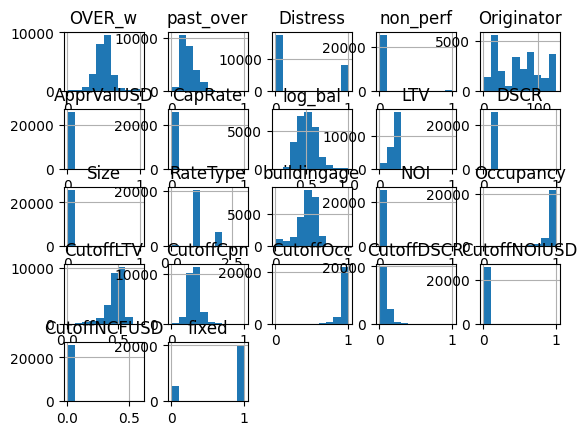

In [27]:
X_train_oversampled.hist()

<Axes: >

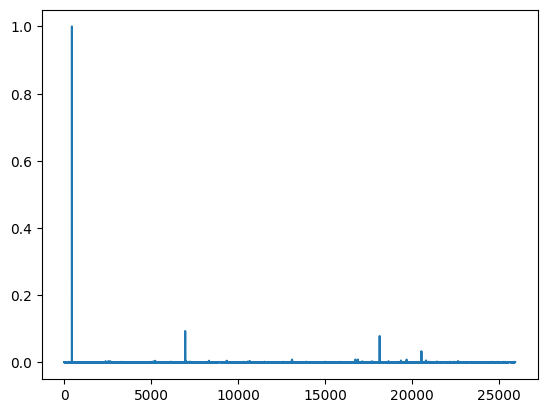

In [28]:
X_train_oversampled['CapRate'].plot()

<Axes: >

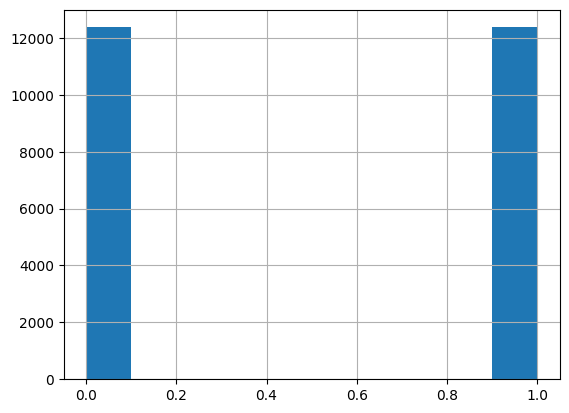

In [114]:
y_train_oversampled.hist()

## Training of models

### EBM

In [29]:
# Explainable Boosting Machine
ebm = ExplainableBoostingClassifier()

ebm.fit(X_train_oversampled, y_train_oversampled)


ExplainableBoostingClassifier()

In [30]:
y_pred = ebm.predict(X_test).astype(float)
y_pred

array([1., 1., 0., ..., 0., 1., 1.])

In [31]:
len(y_pred[y_pred == 0])/ len(y_pred[y_pred == 1])

2.4833715596330275

(array([4331.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
        1744.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

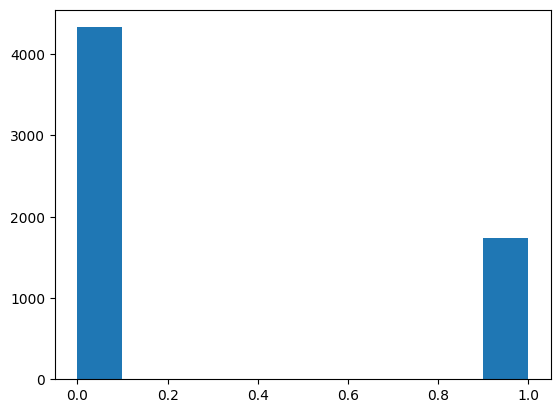

In [32]:
plt.hist(y_pred)

In [33]:
from interpret import show
from interpret import set_visualize_provider
from interpret.provider import InlineProvider

set_visualize_provider(InlineProvider())
show(ebm.explain_global())

In [37]:
show(ebm.explain_global())

In [157]:
confusion_matrix(y_true=y_test.values, y_pred=y_pred)

array([[4329,    0],
       [   0, 1746]])

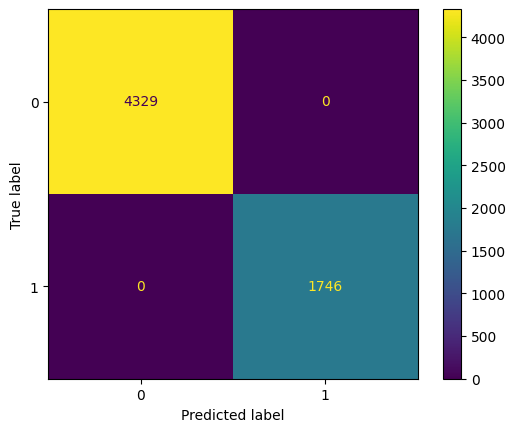

In [158]:
cm = confusion_matrix(y_true=y_test.values, y_pred=y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

In [3]:
interpret.show(ROC(ebm, X_train_oversampled.columns).explain_perf(dat, target))

NameError: name 'ebm' is not defined

In [159]:
# class imbalance
n_positives = len(y_train[y_train == 1.0])
n_negatives = len(y_train[y_train == 0.0])
ratio = n_positives / (n_positives + n_negatives)
print(f'Ratio of samples is: {1-ratio}')


# Calculate Scores
acc_score = accuracy_score(y_test, y_pred)
auc_roc = roc_auc_score(y_test, ebm.predict_proba(X_test)[:, 1])
print(f'Accuracy score: {acc_score}')
print(f'ROC AUC score: {auc_roc}')


Ratio of samples is: 0.7114403292181071
Accuracy score: 1.0
ROC AUC score: 1.0


### Logisitic Regression

In [ ]:
# Logisitc Regression or XGBoost

### NAM

In [11]:
x = np.random.normal(0,2, (500,4))
clean_data = pd.DataFrame(x, columns= ['a', 'b', 'c', 'd'])
target_col = 'a'
clean_data

a         b         c         d
0    0.856429 -1.687874  3.457416  1.111355
1   -1.798300  0.926177 -0.490615 -0.616048
2    0.114466  2.243533  2.366785 -0.143780
3    0.035130  1.689747  1.228694  0.430533
4    0.758226  2.535469  1.495948 -2.172991
..        ...       ...       ...       ...
495  0.729089 -0.984625 -0.019990 -2.932692
496 -0.296244 -2.548708  1.469587  0.979760
497 -1.982923  2.466288 -2.083433 -2.412085
498  0.514214 -1.510945  0.467439 -1.138556
499  2.067466 -2.263729  2.784244  0.007144

[500 rows x 4 columns]

In [25]:
config

namespace(device='cpu',
          seed=2021,
          data_path='data/GALLUP.csv',
          experiment_name='NAM',
          regression=False,
          num_epochs=1,
          lr=0.0003,
          batch_size=1024,
          logdir='output',
          wandb=True,
          hidden_sizes=[64, 32],
          activation='exu',
          optimizer='adam',
          dropout=0.5,
          feature_dropout=0.5,
          decay_rate=0.995,
          l2_regularization=0.5,
          output_regularization=0.5,
          num_basis_functions=1000,
          units_multiplier=2,
          shuffle=True,
          cross_val=False,
          num_folds=5,
          num_splits=3,
          fold_num=1,
          num_models=1,
          num_workers=16,
          save_model_frequency=2,
          save_top_k=3,
          use_dnn=False,
          early_stopping_patience=50)

In [13]:
# Neural Additive Model
config = defaults()
feature_cols = [col for col in clean_data.columns if col != target_col]
nam_dataset = NAMDataset(
    config,
    data_path=clean_data,
    features_columns=feature_cols,
    targets_column=target_col,
)

In [14]:
nam_model = NAM(
    config=config,
    name='Testing_NAM',
    num_inputs=len(nam_dataset[0][0]),
    num_units=get_num_units(config, nam_dataset.features)
)
nam_model

/Users/janik/Library/Python/3.9/lib/python/site-packages/torch/nn/init.py:176: UserWarning: mean is more than 2 std from [a, b] in nn.init.trunc_normal_. The distribution of values may be incorrect.
  return _no_grad_trunc_normal_(tensor, mean, std, a, b)


NAM(
  (dropout): Dropout(p=0.5, inplace=False)
  (feature_nns): ModuleList(
    (0-2): 3 x FeatureNN(
      (dropout): Dropout(p=0.5, inplace=False)
      (model): ModuleList(
        (0): ExU(in_features=1, out_features=1000)
        (1): LinReLU(in_features=1000, out_features=64)
        (2): LinReLU(in_features=64, out_features=32)
        (3): Linear(in_features=32, out_features=1, bias=True)
      )
    )
  )
)

In [18]:
# NAM Training
data_loaders = nam_dataset.train_dataloaders()
for fold, (train_loader, val_loader) in enumerate(data_loaders):
     tb_logger = TensorBoardLogger(
          save_dir=config.logdir,
          name=f'{nam_model.name}',
          version=f'fold_{fold + 1}')

     checkpoint_callback = ModelCheckpoint(
          filename=tb_logger.log_dir + "/{epoch:02d}-{val_loss:.4f}",
          monitor='val_loss',
          save_top_k=config.save_top_k,
          mode='min'
     )
     litmodel = LitNAM(config, nam_model)
     pl.Trainer()
     trainer = pl.Trainer(
          logger=tb_logger,
          max_epochs=config.num_epochs,
          callbacks=checkpoint_callback,
     )
     trainer.fit(
          litmodel,
          train_dataloaders=train_loader,
          val_dataloaders=val_loader)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type | Params
-------------------------------
0 | model | NAM  | 204 K 
-------------------------------
204 K     Trainable params
0         Non-trainable params
204 K     Total params
0.818     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/Users/janik/Library/Python/3.9/lib/python/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:438: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


/Users/janik/Library/Python/3.9/lib/python/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:438: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/Users/janik/Library/Python/3.9/lib/python/site-packages/pytorch_lightning/loops/fit_loop.py:281: PossibleUserWarning: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Epoch 0: 100%|██████████| 1/1 [00:02<00:00,  2.81s/it, v_num=ld_1, train_loss_step=227.0, Accuracy_metric_step=1.000, val_loss_step=-29.4, val_loss_epoch=-29.4, Accuracy_metric_epoch=0.475, train_loss_epoch=227.0]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 1/1 [00:02<00:00,  2.88s/it, v_num=ld_1, train_loss_step=227.0, Accuracy_metric_step=1.000, val_loss_step=-29.4, val_loss_epoch=-29.4, Accuracy_metric_epoch=0.475, train_loss_epoch=227.0]


In [29]:
trainer.logger.experiment.summary

AttributeError: 'SummaryWriter' object has no attribute 'summary'

### NAM Testing and Evaluation

In [22]:
trainer.test(litmodel, dataloaders=nam_dataset.test_dataloaders())

/Users/janik/Library/Python/3.9/lib/python/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:438: PossibleUserWarning: The dataloader, test_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  3.20it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
  Accuracy_metric_epoch             1.0
     test_loss_epoch         33.93817138671875
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss_epoch': 33.93817138671875, 'Accuracy_metric_epoch': 1.0}]

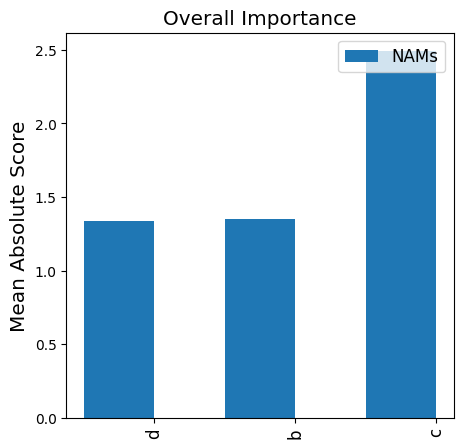

In [23]:
fig = plot_mean_feature_importance(litmodel.model, nam_dataset)

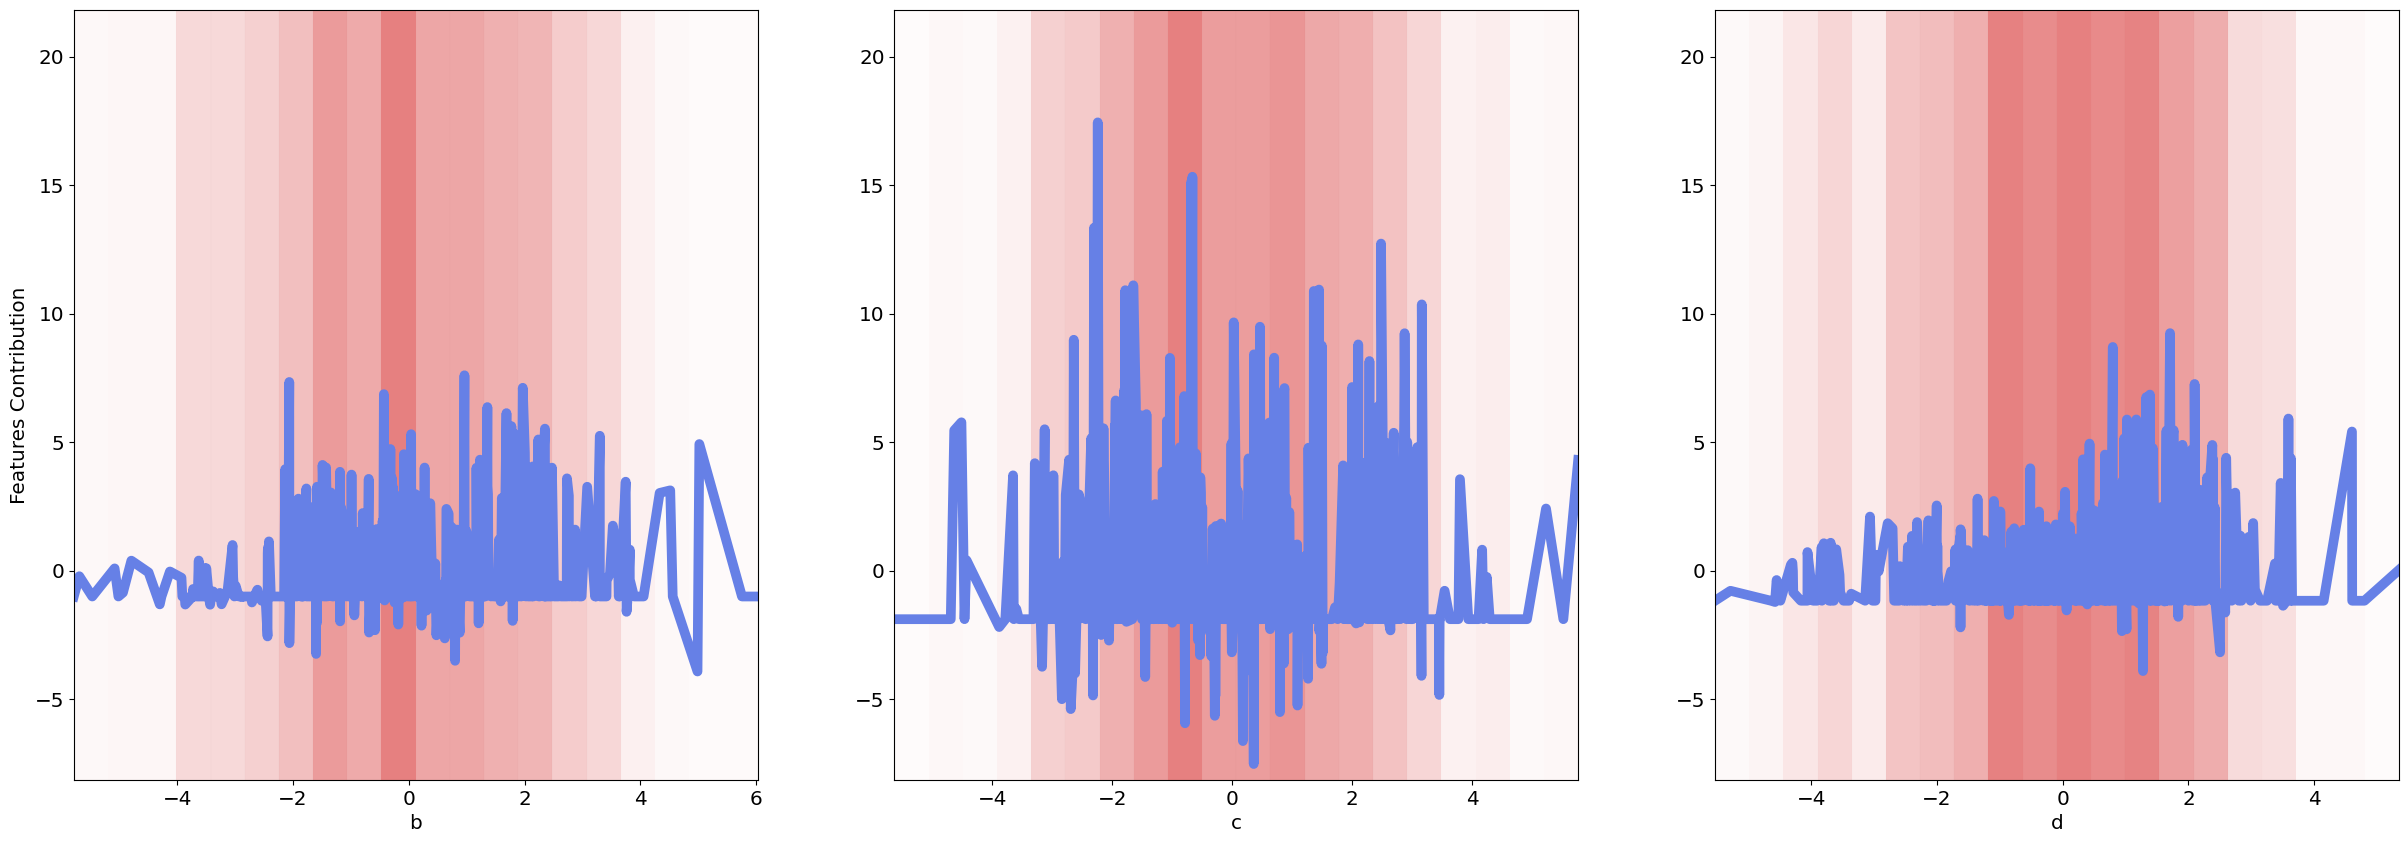

In [24]:
fig = plot_nams(litmodel.model, nam_dataset, num_cols= 3)

# Evaluation

## Anhang

from interpret.glassbox import ExplainableBoostingClassifier
from sklearn.model_selection import RandomizedSearchCV
param_test = {'learning_rate': [0.001,0.005,0.01,0.03],
              'interactions': [5,10,15],
              'max_interaction_bins': [10,15,20],
              'max_rounds': [5000,10000,15000,20000],
              'min_samples_leaf': [2,3,5],
              'max_leaves': [3,5,10]}
n_HP_points_to_test=10
LGBM_clf = LGBMClassifier(random_state=314, n_jobs=-1)
LGBM_gs = RandomizedSearchCV(
    estimator=LGBM_clf,
    param_distributions=param_test,
    n_iter=n_HP_points_to_test,
    scoring="roc_auc",
    cv=3,
    refit=True,
    random_state=314,
    verbose=False,
)
LGBM_gs.fit(X_train, y_train)

for df_name, df in all_data.items():
    display(df_name)
    display(df.columns.to_list())
    display('------------')

def get_scores(clf, X_test, y_true, print_results=False):
    scores = {}
    y_pred = clf.predict(X_test)
    scores['accuracy'] = accuracy_score(y_true=y_true, y_pred=y_pred)
    scores['recall'] = recall_score(y_true=y_true, y_pred=y_pred)
    scores['roc_auc'] = roc_auc_score(y_true=y_true, y_score=clf.predict_proba(X_test))

    if print_results:
        for score_name, score in scores.items():
            print(f'{score_name}: {score}')

    return scores